In [49]:
from sqlalchemy import create_engine, text
import pandas as pd
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries
from functools import partial

# Save Results

## Load mlflow runs

In [51]:
db_port = 5101
db_name = 'cohirf'
w = 'clust9'
# url = f'postgresql://{w}.ceremade.dauphine.lan:{db_port}/{db_name}'
url = f'postgresql://beluccib@localhost:{db_port}/{db_name}'
engine = create_engine(url)
query = 'SELECT experiments.name from experiments'
experiment_names = pd.read_sql(query, engine)['name'].tolist()
# results_dir = Path('~/tab_benchmark/results')
# os.makedirs(results_dir, exist_ok=True)

In [52]:
experiment_names

['Default',
 'classif_huge_cohirf',
 'classif_huge_kmeans',
 'classif_clusters_kmeans',
 'classif_clusters_cohirf',
 'classif_huge_cohirf_sampling',
 'classif_huge_cohirf_minibatch',
 'time_hc_CompleteAgglomerativeClustering_samples',
 'time_hc_WardAgglomerativeClustering_samples',
 'time_hc_OPTICS_samples',
 'time_hc_CompleteAgglomerativeClustering_features',
 'time_hc_Proclus_features',
 'time_hc_WardAgglomerativeClustering_features',
 'time_hc_KMeans_features',
 'time_hc_KMeansProj_samples',
 'time_hc_Clique_samples',
 'time_hc_DBSCAN_features',
 'time_hc_KMeans_samples',
 'time_hc_DBSCAN_samples',
 'time_hc_AffinityPropagation_samples',
 'time_hc_RecursiveClustering_features',
 'time_hc_SpectralSubspaceRandomization_samples',
 'time_hc_KMeansProj_features',
 'time_hc_MeanShift_features',
 'time_hc_HDBSCAN_features',
 'time_hc_OPTICS_features',
 'time_hc_Clique_features',
 'time_hc_IRFLLRR_features',
 'time_hc_RecursiveClustering_samples',
 'time_hc_MeanShift_samples',
 'time_hc_Spe

In [53]:
experiments_names = [exp for exp in experiment_names if exp.find('openml_task') != -1]

In [54]:
params_columns = [
    'model_nickname',
    'n_samples',
    'n_features',
    'n_classes',
    'seed_model',
    'dataset_id',
    'dataset_name',
    'task_id',
    'task_fold',
    # 'model_params/representative_method',
    # 'model_params/n_samples_representative',
    # 'model_params/kernel_kmeans',
    'direction',
    'hpo_metric',
    'standardize'
]

In [55]:
latest_metrics_columns = [
    'fit_model_return_elapsed_time',
    'max_memory_used',
    'n_clusters_',
    'rand_score',
    'adjusted_rand',
    'mutual_info',
    'adjusted_mutual_info',
    'normalized_mutual_info',
    'homogeneity',
    'completeness',
    'v_measure',
    'silhouette',
    'calinski_harabasz_score',
    'davies_bouldin_score',
    'inertia_score',
    'best_n_clusters_',
    'best_rand_score',
    'best_adjusted_rand',
    'best_mutual_info',
    'best_adjusted_mutual_info',
    'best_normalized_mutual_info',
    'best_homogeneity_completeness_v_measure',
    'best_silhouette',
    'best_calinski_harabasz_score',
    'best_davies_bouldin_score',
    'best_inertia_score',
    'best_homogeneity',
    'best_completeness',
    'best_v_measure',
]

In [56]:
tags_columns = [
    'raised_exception',
    'EXCEPTION',
    'parent_run_id',
    'best_child_run_id',
]

In [57]:
# parameters of each model, they are saved as tags for the parent run
parameters = {
    'RecursiveClustering': ['components_size', 'repetitions', 'kmeans_n_clusters'],
    'KMeans': ['n_clusters'],
    'HDBSCAN': ['min_cluster_size'],
    'DBSCAN': ['eps', 'min_samples'],
    'AffinityPropagation': ['damping'],
    'OPTICS': ['min_samples'],
    'SpectralSubspaceRandomization': ['n_similarities', 'sampling_ratio', 'sc_n_clusters'],
    'WardAgglomerativeClustering': ['n_clusters'],
    'Clique': ['n_partitions', 'density_threshold'],
    'IRFLLRR': ['sc_n_clusters', 'p', 'c', 'lambda_', 'alpha'],
    'KMeansProj': ['n_clusters'],
    'Proclus': ['n_clusters', 'avg_dims'],
    'SpectralClustering': ['n_clusters'],
    'SingleAgglomerativeClustering': ['n_clusters'],
    'CompleteAgglomerativeClustering': ['n_clusters'],
    'AverageAgglomerativeClustering': ['n_clusters'],
}
all_model_parameters = [p for model, params in parameters.items() for p in params]
all_model_parameters = list(set(all_model_parameters))
for param in all_model_parameters:
    tags_columns.append(param)

In [58]:
runs_columns = ['run_uuid', 'status', 'start_time', 'end_time']
experiments_columns = []
other_table = 'params'
other_table_keys = params_columns
df_params = get_df_runs_from_mlflow_sql(engine, runs_columns=runs_columns, experiments_columns=experiments_columns, experiments_names=experiments_names, other_table=other_table, other_table_keys=other_table_keys)
df_latest_metrics = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='latest_metrics', other_table_keys=latest_metrics_columns)
df_tags = get_df_runs_from_mlflow_sql(engine, runs_columns=['run_uuid'], experiments_columns=experiments_columns, experiments_names=experiments_names, other_table='tags', other_table_keys=tags_columns)

In [59]:
df_runs_raw = df_params.join(df_latest_metrics)
df_runs_raw = df_runs_raw.join(df_tags)

In [60]:
df_runs_raw_parents = df_runs_raw.copy()
df_runs_raw_parents = df_runs_raw_parents.loc[df_runs_raw_parents['parent_run_id'].isna()]

In [61]:
# get all metrics beside best or last
metrics_columns = [
    'adjusted_rand',
    'silhouette',
    'calinski_harabasz_score',
    'davies_bouldin_score',
    'inertia_score',
]
metrics_columns_query = [f"'{m}'" for m in metrics_columns]
metrics_columns_query = ', '.join(metrics_columns_query)
experiments_names_query = [f"'{name}'" for name in experiments_names]
experiments_names_query = ', '.join(experiments_names_query)
query = f"""
SELECT
	runs.run_uuid,
	metrics."key",
	metrics.value,
	metrics.step 
FROM
	runs
LEFT JOIN metrics ON
	metrics.run_uuid = runs.run_uuid
LEFT JOIN experiments ON 
	experiments.experiment_id = runs.experiment_id  
WHERE 
	metrics."key" IN ({metrics_columns_query})
	AND experiments."name" IN ({experiments_names_query})
"""
df_metrics = pd.read_sql(query, engine)
df_metrics = df_metrics.pivot_table(index=['run_uuid', 'step'], columns='key', values='value')
df_metrics

,key,adjusted_rand,calinski_harabasz_score,davies_bouldin_score,inertia_score,silhouette
run_uuid,step,,,,,
00002ff722c34226b8f45883c9f55cd8,0,0.032074,2.664171,9.414314,393.757603,-0.315711
000032df99e04853a8530661de7e95c8,0,0.000000,-1.000000,1000.000000,404160.000000,-1.000000
00003bdbfdf648e58d0bdc6443d4ab6c,0,0.076417,2.054408,0.959852,22080.695810,0.027600
0000deeede9e418f9d3c3fa9990ab510,0,0.006744,2.956296,0.955354,19994.967247,-0.005143
00032e1c50d74e7b9f68ceb6ba4dd5d2,0,0.018782,129.761905,3.736831,36167.500468,-0.022837
...,...,...,...,...,...,...
fffbb20cb78e433badde512dfbe8ffb4,0,0.134176,2.645751,0.603717,120549.382939,0.087106
fffcd9bf80c746088f1d991de6d447a8,0,-0.014829,2.186486,0.670432,60382.326535,0.128741
fffd84a77a4e4b40852b08e377201a7e,0,0.000000,-1.000000,1000.000000,7619.527370,-1.000000


In [62]:
df_runs_raw_parents

key,status,start_time,end_time,dataset_id,dataset_name,direction,hpo_metric,model_nickname,n_classes,n_features,...,min_samples,n_clusters,n_partitions,n_similarities,p,parent_run_id,raised_exception,repetitions,sampling_ratio,sc_n_clusters
run_uuid,,,,,,,,,,,,,,,,,,,,,
0000465744df45c5a41b84897200db9f,RUNNING,1743447848083,NaN,None,NaN,maximize,adjusted_rand,SpectralSubspaceRandomization,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
000d5c44a2f7471da08254e5ff9972da,FAILED,1743009589803,1.743010e+12,None,NaN,maximize,adjusted_rand,KMeans,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN
001c386600334f3f90102dc422725764,FAILED,1743009727248,1.743010e+12,None,NaN,maximize,adjusted_rand,IRFLLRR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN
001d0885d8ca4ddcb7365661d99a2c31,RUNNING,1743035314092,NaN,None,NaN,maximize,adjusted_rand,IRFLLRR,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0034d41e2e6c4bfc88301551c983fbc3,FAILED,1743011203524,1.743011e+12,None,NaN,maximize,adjusted_rand,HDBSCAN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffeaf1401961405796416e91dc80db0a,FINISHED,1743108382144,1.743108e+12,None,khan-2001,maximize,adjusted_rand,KMeans,NaN,NaN,...,NaN,11,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN
ffeb05191e65412aad1b3033854e076f,FAILED,1743003248571,1.743003e+12,None,NaN,maximize,adjusted_rand,SingleAgglomerativeClustering,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN
fff020511d7e41249df86849108da50f,FAILED,1743001368725,1.743001e+12,None,NaN,maximize,adjusted_rand,Proclus,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN


# Separate our method with two types of representative_method

In [63]:
df_runs_parents = df_runs_raw_parents.copy()

# # fill with default values
# df_runs_parents['model_params/representative_method'] = df_runs_parents['model_params/representative_method'].fillna('closest_overall')
# df_runs_parents['model_params/n_samples_representative'] = 'None' #df_runs_parents['model_params/n_samples_representative'].fillna('None')
# df_runs_parents['model_params/kernel_kmeans'] = df_runs_parents['model_params/kernel_kmeans'].fillna('False')
#
# # fix closest_overall_1000 with new params
# df_runs_parents.loc[(df_runs_parents['model_nickname']=='RecursiveClustering') & (df_runs_parents['model_params/representative_method']=='closest_overall_1000'), 'model_params/n_samples_representative'] = '1000'
# df_runs_parents.loc[(df_runs_parents['model_nickname']=='RecursiveClustering') & (df_runs_parents['model_params/representative_method']=='closest_overall_1000'), 'model_params/representative_method'] = 'closest_overall'
#
# df_runs_parents.loc[df_runs_parents['model_nickname']=='RecursiveClustering', 'model_nickname'] = df_runs_parents.loc[df_runs_parents['model_nickname']=='RecursiveClustering', 'model_nickname'] + '_' + df_runs_parents.loc[df_runs_parents['model_nickname']=='RecursiveClustering', 'model_params/representative_method'] + '_' + df_runs_parents.loc[df_runs_parents['model_nickname']=='RecursiveClustering', 'model_params/n_samples_representative'] + '_' + df_runs_parents.loc[df_runs_parents['model_nickname']=='RecursiveClustering', 'model_params/kernel_kmeans']

# df_runs_parents.loc[(df_runs_parents['model_nickname'] == 'RecursiveClustering') & (df_runs_parents['model_params/representative_method'].isna()), 'model_params/representative_method'] = 'closest_overall'
# df_runs_parents.loc[(df_runs_parents['model_nickname'] == 'RecursiveClustering') & (df_runs_parents['model_params/representative_method'] == 'rbf'), 'model_nickname'] = df_runs_parents.loc[(df_runs_parents['model_nickname'] == 'RecursiveClustering') & (df_runs_parents['model_params/representative_method'] == 'rbf'), 'model_nickname'] + '_rbf'
# df_runs_parents.loc[(df_runs_parents['model_nickname'] == 'RecursiveClustering') & (df_runs_parents['model_params/representative_method'] == 'closest_overall_1000'), 'model_nickname'] = df_runs_parents.loc[(df_runs_parents['model_nickname'] == 'RecursiveClustering') & (df_runs_parents['model_params/representative_method'] == 'closest_overall_1000'), 'model_nickname'] + '_aproximated'


## Delete duplicate runs (if any) and complete some models that cannot run with some datasets

In [64]:
non_duplicate_columns = [
    'model_nickname',
    'task_id',
    'task_fold',
    # 'model_params/normalization',
    'direction',
    'hpo_metric',
    'standardize',
]
df_runs_parents = df_runs_parents.dropna(axis=0, how='all', subset=['best_adjusted_rand']).copy()
df_runs_parents = df_runs_parents.loc[(~df_runs_parents.duplicated(non_duplicate_columns))]

# datasets

In [65]:
dataset_characteristics = pd.read_csv('/home/bbelucci/code/recursive_clustering/characteristics.csv')
dataset_characteristics

,task_id,dataset_id,name,task,evaluation,n_instances,n_features,n_categorical_features,n_continuous_features,n_nans,n_rows_nans,n_classes,url
0,145977,39,ecoli,Supervised Classification,"{'type': 'crossvalidation', 'parameters': {'nu...",336.0,8.0,1.0,7.0,0.0,0.0,8.0,https://www.openml.org/d/39
1,59,61,iris,Supervised Classification,"{'type': 'crossvalidation', 'parameters': {'nu...",150.0,5.0,1.0,4.0,0.0,0.0,3.0,https://www.openml.org/d/61
2,2074,182,satimage,Supervised Classification,"{'type': 'crossvalidation', 'parameters': {'nu...",6430.0,37.0,1.0,36.0,0.0,0.0,6.0,https://www.openml.org/d/182
3,14970,1478,har,Supervised Classification,"{'type': 'crossvalidation', 'parameters': {'nu...",10299.0,562.0,1.0,561.0,0.0,0.0,6.0,https://www.openml.org/d/1478
4,9892,1568,nursery,Supervised Classification,"{'type': 'crossvalidation', 'parameters': {'nu...",12958.0,9.0,9.0,0.0,0.0,0.0,4.0,https://www.openml.org/d/1568
5,146212,40685,shuttle,Supervised Classification,"{'type': 'crossvalidation', 'parameters': {'nu...",58000.0,10.0,1.0,9.0,0.0,0.0,7.0,https://www.openml.org/d/40685
6,146822,40984,segment,Supervised Classification,"{'type': 'crossvalidation', 'parameters': {'nu...",2310.0,20.0,1.0,19.0,0.0,0.0,7.0,https://www.openml.org/d/40984
7,363483,46773,alizadeh-2000-v2,Supervised Classification,"{'type': 'crossvalidation', 'parameters': {'nu...",62.0,2094.0,0.0,2093.0,0.0,0.0,3.0,https://www.openml.org/d/46773
8,363484,46774,alizadeh-2000-v3,Supervised Classification,"{'type': 'crossvalidation', 'parameters': {'nu...",62.0,2092.0,0.0,2091.0,0.0,0.0,4.0,https://www.openml.org/d/46774
9,363485,46775,armstrong-2002-v1,Supervised Classification,"{'type': 'crossvalidation', 'parameters': {'nu...",72.0,1082.0,0.0,1081.0,0.0,0.0,2.0,https://www.openml.org/d/46775


 # Missing

In [66]:
model_nickname = df_runs_parents['model_nickname'].unique().tolist()
model_nickname.sort()
model_nickname

['AffinityPropagation',
 'AverageAgglomerativeClustering',
 'Clique',
 'CompleteAgglomerativeClustering',
 'DBSCAN',
 'HDBSCAN',
 'IRFLLRR',
 'KMeans',
 'KMeansProj',
 'MeanShift',
 'OPTICS',
 'Proclus',
 'RecursiveClustering',
 'RecursiveClustering_full',
 'SingleAgglomerativeClustering',
 'SpectralClustering',
 'SpectralSubspaceRandomization',
 'WardAgglomerativeClustering']

In [67]:
non_duplicate_columns = [
    'model_nickname',
    'task_id',
    'task_fold',
    'hpo_metric',
    'standardize',
]

In [68]:
# dataset_id = datasets['dataset_id'].tolist()
task_id = [145977, 59, 2074, 14970, 9892, 146212, 146822, 363483, 363484, 363485, 363486, 363487, 363488, 363489, 363490, 363491, 363492, 363493]
task_id = [145977, 59, 2074, 14970, 9892, 146212, 146822, 363493, 363483, 363489]
task_id = [str(d) for d in task_id]
task_fold = [str(i) for i in range(10)]
hpo_metric = ['adjusted_rand']
standardize = ['True']
model_nickname = [
    'AffinityPropagation',
    'AverageAgglomerativeClustering',
    'Clique',
    'CompleteAgglomerativeClustering',
    'DBSCAN',
    'HDBSCAN',
    'IRFLLRR',
    'KMeans',
    'KMeansProj',
    'MeanShift',
    'OPTICS',
    'Proclus',
    'RecursiveClustering',
    'RecursiveClustering_full',
    'SingleAgglomerativeClustering',
    'SpectralClustering',
    'SpectralSubspaceRandomization',
    'WardAgglomerativeClustering'
]
columns_names = non_duplicate_columns
should_contain_values = [model_nickname, task_id, task_fold, hpo_metric, standardize]
df_missing = get_missing_entries(df_runs_parents, columns_names, should_contain_values)

In [69]:
df_missing

,model_nickname,task_id,task_fold,hpo_metric,standardize
0,AffinityPropagation,146212,0,adjusted_rand,True
1,AffinityPropagation,146212,1,adjusted_rand,True
2,AffinityPropagation,146212,2,adjusted_rand,True
3,AffinityPropagation,146212,3,adjusted_rand,True
4,AffinityPropagation,146212,4,adjusted_rand,True
...,...,...,...,...,...
216,SpectralSubspaceRandomization,363493,3,adjusted_rand,True
217,SpectralSubspaceRandomization,363493,4,adjusted_rand,True
218,SpectralSubspaceRandomization,363493,5,adjusted_rand,True
219,SpectralSubspaceRandomization,363493,6,adjusted_rand,True


In [31]:
df = df_runs_raw_parents.copy()
df = df.set_index(['model_nickname', 'task_id', 'task_fold', 'hpo_metric', 'standardize'])[['raised_exception', 'EXCEPTION']]
df_missing = df_missing.join(df, on=['model_nickname', 'task_id', 'task_fold', 'hpo_metric', 'standardize'])
df_missing = df_missing.loc[df_missing['model_nickname']=='SpectralSubspaceRandomization']
df_missing.sort_values(['model_nickname', 'task_id', 'task_fold'])

,model_nickname,task_id,task_fold,hpo_metric,standardize,raised_exception,EXCEPTION
327,SpectralSubspaceRandomization,145977,1,adjusted_rand,True,True,"`dataset_id` must be one of `str` or `int`, no..."
327,SpectralSubspaceRandomization,145977,1,adjusted_rand,True,NaN,NaN
327,SpectralSubspaceRandomization,145977,1,adjusted_rand,True,NaN,NaN
328,SpectralSubspaceRandomization,145977,2,adjusted_rand,True,NaN,NaN
328,SpectralSubspaceRandomization,145977,2,adjusted_rand,True,True,"`dataset_id` must be one of `str` or `int`, no..."
...,...,...,...,...,...,...,...
361,SpectralSubspaceRandomization,9892,8,adjusted_rand,True,True,"`dataset_id` must be one of `str` or `int`, no..."
361,SpectralSubspaceRandomization,9892,8,adjusted_rand,True,NaN,NaN
362,SpectralSubspaceRandomization,9892,9,adjusted_rand,True,True,"`dataset_id` must be one of `str` or `int`, no..."
362,SpectralSubspaceRandomization,9892,9,adjusted_rand,True,NaN,NaN


In [32]:
print(*df_missing['task_id'].unique().tolist()
,sep=',')

145977,2074,14970,9892,146212,146822,363492,363493


# Get common combinations


In [21]:
from ml_experiments.analyze import get_df_runs_from_mlflow_sql, get_missing_entries, get_common_combinations, get_df_with_combinations, get_dfs_means_stds_both, friedman_nemenyi_test
import matplotlib.pyplot as plt
import scikit_posthocs as sp

In [29]:
model_nickname = [
    # 'AffinityPropagation',
    'AverageAgglomerativeClustering',
    # 'Clique',
    'CompleteAgglomerativeClustering',
    'DBSCAN',
    'HDBSCAN',
    # 'IRFLLRR',
    'KMeans',
    # 'KMeansProj',
    'MeanShift',
    'OPTICS',
    'Proclus',
    'RecursiveClustering',
    'RecursiveClustering_full',
    'SingleAgglomerativeClustering',
    # 'SpectralClustering',
    # 'SpectralSubspaceRandomization',
    'WardAgglomerativeClustering'
]
df = df_runs_parents.copy()
df = df.loc[df['model_nickname'].isin(model_nickname)]
df = df.loc[df['hpo_metric'] == 'adjusted_rand']
df = df.loc[df['standardize'] == 'True']
column = 'model_nickname'
combination_columns = ['task_id', 'task_fold']
common_combinations = get_common_combinations(df, column, combination_columns)
df_common = get_df_with_combinations(df, combination_columns, common_combinations)

In [30]:
df_common['task_id'].unique()

array(['2074', '145977', '363488', '363493', '363486', '363492', '363483',
       '14970', '146822', '363485', '363484', '363487', '363491', '59',
       '363490', '363489'], dtype=object)

# CDD

In [31]:
dataset_characteristics[['name', 'task_id', 'n_instances', 'n_features','n_classes']].sort_values(['n_instances'])

,name,task_id,n_instances,n_features,n_classes
10,bittner-2000,363486,38.0,2202.0,2.0
11,bredel-2005,363487,50.0,1740.0,3.0
7,alizadeh-2000-v2,363483,62.0,2094.0,3.0
8,alizadeh-2000-v3,363484,62.0,2092.0,4.0
13,garber-2001,363489,66.0,4554.0,4.0
9,armstrong-2002-v1,363485,72.0,1082.0,2.0
14,golub-1999-v2,363490,72.0,1869.0,3.0
15,khan-2001,363491,83.0,1070.0,4.0
12,chowdary-2006,363488,104.0,183.0,2.0
1,iris,59,150.0,5.0,3.0


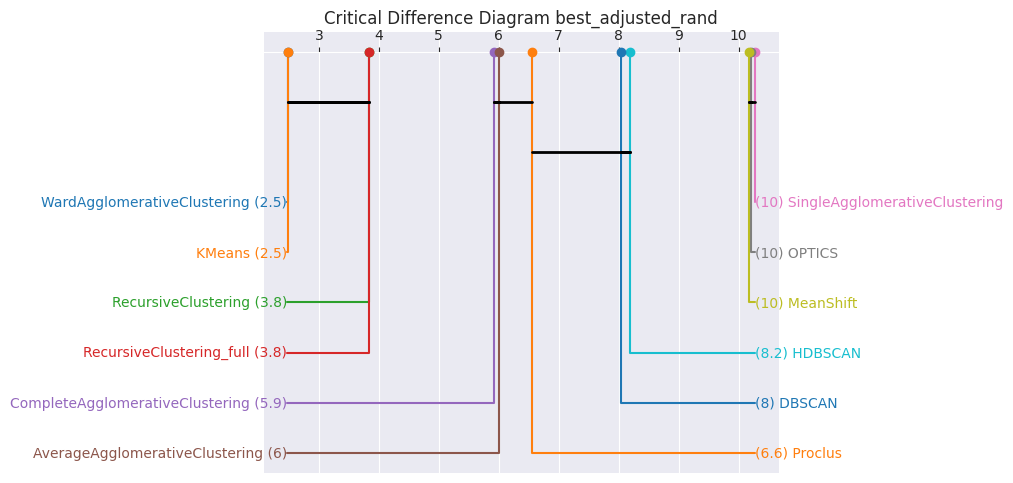

In [32]:
df = df_common.copy()
task_ids = [145977, 59, 2074, 14970, 9892, 146212, 146822]#, 363483, 363484, 363485, 363486, 363487, 363488, 363489, 363490, 363491, 363492, 363493]
task_ids = [145977, 59, 2074, 14970, 9892, 146212, 146822, 363483, 363489, 363493]#, 363483, 363484, 363485, 363486, 363487, 363488, 363489, 363490, 363491, 363492, 363493]
task_ids = [str(d) for d in task_ids]
df = df.loc[df['task_id'].isin(task_ids)]
df['task_id_task_fold'] = df['task_id'] + '-' + df['task_fold']
df['task_id_task_fold_id'] = df['task_id_task_fold'].astype('category').cat.codes
metric = 'best_adjusted_rand'
ascending_rank = False
model_column = 'model_nickname'
block_column = 'task_id_task_fold'
block_id_column = 'task_id_task_fold_id'
alpha = 0.95
res_friedman, res_nemenyi, mean_rank = friedman_nemenyi_test(df, model_column, block_column,
                                                             metric, ascending_rank, alpha, block_id_column=block_id_column)
if res_nemenyi is not None and mean_rank is not None:
    plt.subplots(figsize=(10, 5))
    plt.title(f'Critical Difference Diagram {metric}')
    sp.critical_difference_diagram(mean_rank, res_nemenyi)
    plt.tight_layout()

In [27]:
df

key,status,start_time,end_time,dataset_id,dataset_name,direction,hpo_metric,model_nickname,n_classes,n_features,...,n_partitions,n_similarities,p,parent_run_id,raised_exception,repetitions,sampling_ratio,sc_n_clusters,task_id_task_fold,task_id_task_fold_id
run_uuid,,,,,,,,,,,,,,,,,,,,,
0074312d5d00455ca43dbc4c0c7212e5,FINISHED,1743034669923,1.743035e+12,None,ecoli,maximize,adjusted_rand,RecursiveClustering,NaN,NaN,...,NaN,NaN,NaN,NaN,False,7,NaN,NaN,145977-6,3
00a3de38a24c4d2499e99478bba4a2fe,FINISHED,1743038240018,1.743038e+12,None,chowdary-2006,maximize,adjusted_rand,HDBSCAN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,363488-8,64
0103a899f47c41d69ed79ea7dac0f504,FINISHED,1743043590938,1.743044e+12,None,alizadeh-2000-v3,maximize,adjusted_rand,Clique,NaN,NaN,...,100,NaN,NaN,NaN,False,NaN,NaN,NaN,363484-9,25
0114dd21df3f403cb47292f2461c91cc,FINISHED,1743037740225,1.743038e+12,None,bittner-2000,maximize,adjusted_rand,DBSCAN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,363486-9,45
0137e3450c8a439ab0585f95ec0a2e4a,FINISHED,1743038950684,1.743039e+12,None,alizadeh-2000-v2,maximize,adjusted_rand,Proclus,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,363483-1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ff4342c4d8cd4237ae4f10f5837f1fc5,FINISHED,1743034644439,1.743035e+12,None,ecoli,maximize,adjusted_rand,DBSCAN,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,145977-6,3
ff59004f2f48485dabf19114021980d1,FINISHED,1743039846456,1.743040e+12,None,armstrong-2002-v1,maximize,adjusted_rand,SpectralSubspaceRandomization,NaN,NaN,...,NaN,22,NaN,NaN,False,NaN,0.7997205320336309,2,363485-1,27
ffbe2d6ca2d94e25b1173f4ccc2ea728,FINISHED,1743039929762,1.743040e+12,None,bredel-2005,maximize,adjusted_rand,Proclus,NaN,NaN,...,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,363487-7,53


# Plots

In [33]:
all_model_parameters

['sampling_ratio',
 'p',
 'lambda_',
 'components_size',
 'eps',
 'n_clusters',
 'density_threshold',
 'kmeans_n_clusters',
 'c',
 'repetitions',
 'damping',
 'n_similarities',
 'n_partitions',
 'alpha',
 'sc_n_clusters',
 'avg_dims',
 'min_cluster_size',
 'min_samples']

In [34]:
def get_parameters_string(row):
    parameter_names = {
        'components_size': 'q',
        'repetitions': 'R',
        'kmeans_n_clusters': 'C',
        'n_clusters': 'C',
        'min_cluster_size': 'C_{\\text{min}}',
        'eps': '\epsilon',
        'min_samples': 'n_{\\text{min}}',
        'damping': '\lambda',
        'n_similarities': 'm',
        'sampling_ratio': 'r',
        'sc_n_clusters': 'C',
        'density_threshold': '\\tau',
        'n_partitions': 'P',
        'avg_dims': 'd',
        'lambda_': '\lambda',
        'alpha': '\\alpha',
        'c': 'c',
        'p': 'p',
    }
    first = True
    str = ''
    for p in all_model_parameters:
        if not pd.isna(row[p]):
            if not first:
                str += '; '
            else:
                first = False
            value = float(row[p])
            if value.is_integer():
                value = int(value)
                str += f'${parameter_names[p]}={value}$'
            else:
                str += f'${parameter_names[p]}={value:0.2f}$'
    return str        

In [35]:
def highlight_max(df, column_name, level=0):
    df_column = df[column_name]
    max_values = df_column.groupby(level=level).transform('max')
    is_highlighted = df_column.round(3) == max_values.round(3)
    df_css = df.copy().astype(str)
    df_css.loc[:, :] = ''
    df_css[is_highlighted] = 'font-weight: bold'
    return df_css

In [36]:
def highlight_max_index(series_index, df_column, level=0):
    max_values = df_column.groupby(level=level).transform('max')
    is_highlighted = df_column.round(3) == max_values.round(3)
    series_css = series_index.copy().astype(str)
    series_css[:] = ''
    series_css[is_highlighted.values] = 'font-weight: bold'
    return series_css

In [37]:
def underline_2nd_max(df, column_name, level=0):
    df_column = df[column_name]
    # get the second max value
    second_max_values = df_column.groupby(level=level).transform(lambda x: x.nlargest(2).iloc[-1])
    is_underlined = df_column.round(3) == second_max_values.round(3)
    df_css = df.copy().astype(str)
    df_css.loc[:, :] = ''
    df_css[is_underlined] = 'underline: --latex--rwrap'
    return df_css

In [38]:
def underline_2nd_max_index(series_index, df_column, level=0):
    # get the second max value
    second_max_values = df_column.groupby(level=level).transform(lambda x: x.nlargest(2).iloc[-1])
    is_underlined = df_column.round(3) == second_max_values.round(3)
    series_css = series_index.copy().astype(str)
    series_css.loc[:] = ''
    series_css[is_underlined.values] = 'underline: --latex--rwrap'
    return series_css

## Some Models

The following will provide the latex code for a clean table, we only need to make a little adjustement in the first line to delete the "key" and have only one header. For the longtable environment (full data) we need to add the "\*" at the end of lines we dont want to have a page break. We also should replace the entire begin{table} ... end{table} by begin{longtable} ... end{longtable} in the latex file.


In [39]:
model_nickname = df_runs_parents['model_nickname'].unique().tolist()
model_nickname.sort()
model_nickname

['AffinityPropagation',
 'AverageAgglomerativeClustering',
 'Clique',
 'CompleteAgglomerativeClustering',
 'DBSCAN',
 'HDBSCAN',
 'IRFLLRR',
 'KMeans',
 'KMeansProj',
 'MeanShift',
 'OPTICS',
 'Proclus',
 'RecursiveClustering',
 'RecursiveClustering_full',
 'SingleAgglomerativeClustering',
 'SpectralClustering',
 'SpectralSubspaceRandomization',
 'WardAgglomerativeClustering']

In [40]:
task_id = [145977, 59, 2074, 14970, 9892, 146212, 146822]#, 363483, 363484, 363485, 363486, 363487, 363488, 363489, 363490, 363491, 363492, 363493]
task_id = [str(d) for d in task_id]
df = df_runs_parents.copy()
df = df.loc[df['task_id'].isin(task_id)]
df = df.loc[df['hpo_metric'] == 'adjusted_rand']
df = df.loc[df['standardize'] == 'True']
df['Parameters'] = df.apply(get_parameters_string, axis=1)
models_names = {
    'AffinityPropagation': 'Affinity Propagation',
    'AverageAgglomerativeClustering': 'Average Agglomerative',
    'Clique': 'Clique',
    'CompleteAgglomerativeClustering': 'Complete Agglomerative',
    'DBSCAN': 'DBSCAN',
    'HDBSCAN': 'HDBSCAN',
    'IRFLLRR': 'IRFLLRR',
    'KMeans': 'K-Means',
    'KMeansProj': 'Projective K-Means',
    'MeanShift': 'Mean Shift',
    'OPTICS': 'OPTICS',
    'Proclus': 'Proclus',
    'RecursiveClustering': 'CoHiRF',
    'RecursiveClustering_full': 'CoHiRF-full',
    'SingleAgglomerativeClustering': 'Single Agglomerative',
    'SpectralClustering': 'Spectral Clustering',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.replace({'model_nickname': models_names})
df = df[['model_nickname', 'dataset_name', 'best_adjusted_rand', 'fit_model_return_elapsed_time', 'task_fold']]
df = df.groupby(['dataset_name', 'model_nickname']).agg({'best_adjusted_rand': ['mean', 'std'], 'fit_model_return_elapsed_time': ['mean', 'std']})

In [29]:

# get time of the child run
df_child = df_runs_raw.copy()
df_child = df_child[['parent_run_id', 'fit_model_return_elapsed_time']]
df_child = df_child.rename(columns={'fit_model_return_elapsed_time': 'Time (s)'})
df = df.join(df_child.set_index('parent_run_id'), on='run_uuid', rsuffix='_child')
df = df.loc[df['dataset_id'].isin(datasets_ids)]
df = df.loc[df['model_nickname'].isin(models_nicknames)]
df = df.loc[df['hpo_metric'] == 'adjusted_rand']
df = df.loc[df['standardize'] == 'True']
df['Parameters'] = df.apply(get_parameters_string, axis=1)
df = df[['model_nickname', 'dataset_name', 'best_adjusted_rand', 'Parameters', 'Time (s)']]
df = df.loc[~((df['model_nickname'] == 'RecursiveClustering_aproximated') & (df['dataset_name'].isin(['iris', 'ecoli'])))]
models_names = {
    'RecursiveClustering_closest_overall_None_False': 'CoHiRF',
    'RecursiveClustering_rbf': 'CoHiRF-RBF',
    'RecursiveClustering_aproximated': 'CoHiRF-1000',
    'KMeans': 'K-Means',
    'HDBSCAN': 'HDBSCAN',
    'DBSCAN': 'DBSCAN',
    'AffinityPropagation': 'Affinity Propagation',
    'OPTICS': 'OPTICS',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.replace({'model_nickname': models_names})
df = df.rename(columns={'best_adjusted_rand': 'ARI', 'model_nickname': 'Model', 'dataset_name': 'Dataset'})
df = df.groupby(['Dataset', 'Model']).agg({'ARI': 'mean', 'Time (s)': 'first', 'Parameters': 'first'})

In [30]:
# with time, appendix
df_latex = df.copy()
highlight_max_ari = partial(highlight_max, column_name='ARI')
highlight_max_ari_index = partial(highlight_max_index, df_column=df_latex['ARI'])
underline_2nd_max_ari = partial(underline_2nd_max, column_name='ARI')
underline_2nd_max_ari_index = partial(underline_2nd_max_index, df_column=df_latex['ARI'])
print(df_latex.style.apply(highlight_max_ari, subset='ARI', axis=None).apply_index(highlight_max_ari_index,'index', level=1).apply(underline_2nd_max_ari, subset='ARI', axis=None).apply_index(underline_2nd_max_ari_index, 'index', level=1).format(precision=3, na_rep='No Run', subset='ARI').format(formatter='{:4.3f}',subset='Time (s)').to_latex(hrules=True, clines='skip-last;data', convert_css=True, column_format='llrrl'))

\begin{tabular}{llrrl}
\toprule
 & key & ARI & Time (s) & Parameters \\
Dataset & Model &  &  &  \\
\midrule
\multirow[c]{7}{*}{ecoli} & Affinity Propagation & 0.248 & 0.073 & $\lambda=0.58$ \\
 & DBSCAN & 0.345 & 0.018 & $n_{\text{min}}=7$; $\epsilon=0.78$ \\
 & HDBSCAN & 0.398 & 0.018 & $C_{\text{min}}=10$ \\
 & K-Means & 0.719 & 0.006 & $C=6$ \\
 & OPTICS & 0.314 & 5.057 & $n_{\text{min}}=10$ \\
 & \underline{SC-SRGF} & \underline{0.723} & 2.414 & $C=4$; $m=15$; $r=0.80$ \\
 & \bfseries Ward's Method & \bfseries 0.735 & 0.006 & $C=7$ \\
\cline{1-5}
\multirow[c]{7}{*}{har} & Affinity Propagation & 0.313 & 194.025 & $\lambda=1.00$ \\
 & DBSCAN & 0.302 & 2.448 & $n_{\text{min}}=3$; $\epsilon=13.91$ \\
 & HDBSCAN & 0.287 & 53.270 & $C_{\text{min}}=6$ \\
 & K-Means & 0.438 & 0.384 & $C=9$ \\
 & OPTICS & 0.001 & 276.537 & $n_{\text{min}}=4$ \\
 & \bfseries SC-SRGF & \bfseries 0.546 & 3521.249 & $C=20$; $m=21$; $r=0.45$ \\
 & \underline{Ward's Method} & \underline{0.511} & 21.875 & $C=4$ \

In [31]:
# no time, main text
df_latex = df.copy()[['ARI', 'Parameters']]
highlight_max_ari = partial(highlight_max, column_name='ARI')
highlight_max_ari_index = partial(highlight_max_index, df_column=df_latex['ARI'])
underline_2nd_max_ari = partial(underline_2nd_max, column_name='ARI')
underline_2nd_max_ari_index = partial(underline_2nd_max_index, df_column=df_latex['ARI'])
print(df_latex.style.apply(highlight_max_ari, subset='ARI', axis=None).apply_index(highlight_max_ari_index,'index', level=1).apply(underline_2nd_max_ari, subset='ARI', axis=None).apply_index(underline_2nd_max_ari_index, 'index', level=1).format(precision=3, na_rep='No Run', subset='ARI').to_latex(hrules=True, clines='skip-last;data', convert_css=True, column_format='p{0.95cm}lp{0.5cm}l'))

\begin{tabular}{p{0.95cm}lp{0.5cm}l}
\toprule
 & key & ARI & Parameters \\
Dataset & Model &  &  \\
\midrule
\multirow[c]{7}{*}{ecoli} & Affinity Propagation & 0.248 & $\lambda=0.58$ \\
 & DBSCAN & 0.345 & $n_{\text{min}}=7$; $\epsilon=0.78$ \\
 & HDBSCAN & 0.398 & $C_{\text{min}}=10$ \\
 & K-Means & 0.719 & $C=6$ \\
 & OPTICS & 0.314 & $n_{\text{min}}=10$ \\
 & \underline{SC-SRGF} & \underline{0.723} & $C=4$; $m=15$; $r=0.80$ \\
 & \bfseries Ward's Method & \bfseries 0.735 & $C=7$ \\
\cline{1-4}
\multirow[c]{7}{*}{har} & Affinity Propagation & 0.313 & $\lambda=1.00$ \\
 & DBSCAN & 0.302 & $n_{\text{min}}=3$; $\epsilon=13.91$ \\
 & HDBSCAN & 0.287 & $C_{\text{min}}=6$ \\
 & K-Means & 0.438 & $C=9$ \\
 & OPTICS & 0.001 & $n_{\text{min}}=4$ \\
 & \bfseries SC-SRGF & \bfseries 0.546 & $C=20$; $m=21$; $r=0.45$ \\
 & \underline{Ward's Method} & \underline{0.511} & $C=4$ \\
\cline{1-4}
\multirow[c]{7}{*}{iris} & Affinity Propagation & 0.477 & $\lambda=0.98$ \\
 & DBSCAN & 0.558 & $n_{\text{m

## All models

In [70]:
# for some reason the css conversion dont work with longtable, so we slightly modify the css for latex
def highlight_max(df, column_name, level=0):
    df_column = df[column_name]
    max_values = df_column.groupby(level=level).transform('max')
    is_highlighted = df_column.round(3) == max_values.round(3)
    df_css = df.copy().astype(str)
    df_css.loc[:, :] = ''
    df_css[is_highlighted] = 'bfseries: '
    return df_css


def highlight_max_index(series_index, df_column, level=0):
    max_values = df_column.groupby(level=level).transform('max')
    is_highlighted = df_column.round(3) == max_values.round(3)
    series_css = series_index.copy().astype(str)
    series_css[:] = ''
    series_css[is_highlighted.values] = 'bfseries: '
    return series_css


def underline_2nd_max(df, column_name, level=0):
    df_column = df[column_name]
    # get the second max value
    second_max_values = df_column.groupby(level=level).transform(lambda x: x.nlargest(2).iloc[-1])
    is_underlined = df_column.round(3) == second_max_values.round(3)
    df_css = df.copy().astype(str)
    df_css.loc[:, :] = ''
    df_css[is_underlined] = 'underline: --rwrap'
    return df_css


def underline_2nd_max_index(series_index, df_column, level=0):
    # get the second max value
    second_max_values = df_column.groupby(level=level).transform(lambda x: x.nlargest(2).iloc[-1])
    is_underlined = df_column.round(3) == second_max_values.round(3)
    series_css = series_index.copy().astype(str)
    series_css.loc[:] = ''
    series_css[is_underlined.values] = 'underline: --rwrap'
    return series_css

In [71]:
model_nickname

['AffinityPropagation',
 'AverageAgglomerativeClustering',
 'Clique',
 'CompleteAgglomerativeClustering',
 'DBSCAN',
 'HDBSCAN',
 'IRFLLRR',
 'KMeans',
 'KMeansProj',
 'MeanShift',
 'OPTICS',
 'Proclus',
 'RecursiveClustering',
 'RecursiveClustering_full',
 'SingleAgglomerativeClustering',
 'SpectralClustering',
 'SpectralSubspaceRandomization',
 'WardAgglomerativeClustering']

In [74]:
# task_id = [145977, 59, 2074, 14970, 9892, 146212, 146822]#, 363483, 363484, 363485, 363486, 363487, 363488, 363489, 363490, 363491, 363492, 363493]
task_id = [145977, 59, 2074, 14970, 9892, 146212, 146822, 363483, 363489, 363493]
task_id = [str(d) for d in task_id]
df = df_runs_parents.copy()
df = df.loc[df['task_id'].isin(task_id)]
df = df.loc[df['hpo_metric'] == 'adjusted_rand']
df = df.loc[df['standardize'] == 'True']
df_child = df_runs_raw.copy()
df_child = df_child['fit_model_return_elapsed_time']
df = df.join(df_child, on='best_child_run_id', rsuffix='_child')
df['Parameters'] = df.apply(get_parameters_string, axis=1)
models_names = {
    'AffinityPropagation': 'Affinity Propagation',
    'AverageAgglomerativeClustering': 'Average Agglomerative',
    'Clique': 'Clique',
    'CompleteAgglomerativeClustering': 'Complete Agglomerative',
    'DBSCAN': 'DBSCAN',
    'HDBSCAN': 'HDBSCAN',
    'IRFLLRR': 'IRFLLRR',
    'KMeans': 'K-Means',
    'KMeansProj': 'Projective K-Means',
    'MeanShift': 'Mean Shift',
    'OPTICS': 'OPTICS',
    'Proclus': 'Proclus',
    'RecursiveClustering': 'CoHiRF',
    'RecursiveClustering_full': 'CoHiRF-full',
    'SingleAgglomerativeClustering': 'Single Agglomerative',
    'SpectralClustering': 'Spectral Clustering',
    'SpectralSubspaceRandomization': 'SC-SRGF',
    'WardAgglomerativeClustering': "Ward's Method",
}
df = df.replace({'model_nickname': models_names})
df = df[['model_nickname', 'dataset_name', 'best_adjusted_rand', 'fit_model_return_elapsed_time_child', 'task_fold', 'best_normalized_mutual_info', 'best_silhouette', 'best_davies_bouldin_score']]
df = df.rename(columns={'model_nickname': 'Model', 'dataset_name': 'Dataset'})
df = df.groupby(['Dataset', 'Model']).agg({'best_adjusted_rand': ['mean', 'std'], 'fit_model_return_elapsed_time_child': ['mean', 'std']})
df.columns = [' '.join(col).strip() for col in df.columns.values]
df = df.rename(columns={'best_adjusted_rand mean': 'ARI', 'best_adjusted_rand std': 'ARI (std)', 'fit_model_return_elapsed_time_child mean': 'Time (s)', 'fit_model_return_elapsed_time_child std': 'Time (s) (std)'})

In [75]:
df

ARI  ARI (std)    Time (s)  \
Dataset          Model                                                    
alizadeh-2000-v2 Affinity Propagation   0.362064   0.084911    0.013566   
                 Average Agglomerative  0.771678   0.091747    0.017001   
                 Clique                 0.020313   0.056185    0.118140   
                 CoHiRF                 0.780027   0.096430    0.026545   
                 CoHiRF-full            0.780027   0.096430    0.023427   
...                                          ...        ...         ...   
shuttle          OPTICS                 0.017176   0.002349  713.898967   
                 Proclus                0.440279   0.150834   40.846567   
                 Projective K-Means     0.554287   0.198500  315.800529   
                 Single Agglomerative   0.002763   0.000216   19.204759   
                 Ward's Method          0.469684   0.055303  137.103773   

                                        Time (s) (std)  
Dataset          Model                                  
alizadeh-2000-v2 Affinity Propagation         0.002795  
                 Average Agglomerative        0.004379  
                 Clique                       0.009251  
                 CoHiRF                       0.012396  
                 CoHiRF-full                  0.009604  
...                                                ...  
shuttle          OPTICS                      18.351687  
                 Proclus                      6.542114  
                 Projective K-Means         492.166416  
                 Single Agglomerative         0.647182  
                 Ward's Method               10.777039  

[164 rows x 4 columns]

In [77]:
# with time, appendix
df_latex = df.copy()
highlight_max_ari = partial(highlight_max, column_name='ARI')
highlight_max_ari_index = partial(highlight_max_index, df_column=df_latex['ARI'])
underline_2nd_max_ari = partial(underline_2nd_max, column_name='ARI')
underline_2nd_max_ari_index = partial(underline_2nd_max_index, df_column=df_latex['ARI'])
print(df_latex.style.apply(highlight_max_ari, subset='ARI', axis=None).apply_index(highlight_max_ari_index,'index', level=1).apply(underline_2nd_max_ari, subset='ARI', axis=None).apply_index(underline_2nd_max_ari_index, 'index', level=1).format(precision=3, na_rep='No Run', subset=['ARI', 'ARI (std)']).format(formatter='{:4.3f}',subset=['Time (s)', 'Time (s) (std)']).to_latex(hrules=True, clines='skip-last;data', convert_css=False, column_format='llrrrr', environment='longtable'))

\begin{longtable}{llrrrr}
\toprule
 &  & ARI & ARI (std) & Time (s) & Time (s) (std) \\
Dataset & Model &  &  &  &  \\
\midrule
\endfirsthead
\toprule
 &  & ARI & ARI (std) & Time (s) & Time (s) (std) \\
Dataset & Model &  &  &  &  \\
\midrule
\endhead
\midrule
\multicolumn{6}{r}{Continued on next page} \\
\midrule
\endfoot
\bottomrule
\endlastfoot
\multirow[c]{18}{*}{alizadeh-2000-v2} & Affinity Propagation & 0.362 & 0.085 & 0.014 & 0.003 \\
 & Average Agglomerative & 0.772 & 0.092 & 0.017 & 0.004 \\
 & Clique & 0.020 & 0.056 & 0.118 & 0.009 \\
 & CoHiRF & 0.780 & 0.096 & 0.027 & 0.012 \\
 & CoHiRF-full & 0.780 & 0.096 & 0.023 & 0.010 \\
 & Complete Agglomerative & 0.647 & 0.138 & 0.013 & 0.005 \\
 & DBSCAN & 0.251 & 0.049 & 0.010 & 0.000 \\
 & HDBSCAN & 0.176 & 0.047 & 0.025 & 0.001 \\
 & IRFLLRR & 0.050 & 0.038 & 3.341 & 0.187 \\
 & \underline{K-Means} & \underline{0.816} & 0.048 & 0.011 & 0.001 \\
 & Mean Shift & -0.038 & 0.017 & 2.199 & 0.125 \\
 & OPTICS & 0.372 & 0.078 & 0.045 &

# Debug and explore

In [106]:
df = df_runs_raw_parents.copy()

In [107]:
df

key,status,start_time,end_time,dataset_id,dataset_name,direction,hpo_metric,model_nickname,n_classes,n_features,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
0018714386f44f95ab7141d480ce09f0,FINISHED,1737557036103,1.737557e+12,1044,eye_movements,maximize,adjusted_rand,HDBSCAN,NaN,NaN,...,422.740,0.003246,6.0,0.005303,0.358073,0.527841,NaN,756cc869acc94fed89376ae563e075a2,NaN,False
00502ff54da4466191d5fadd2ab0f945,FINISHED,1737556950053,1.737557e+12,7,audiology,maximize,adjusted_rand,HDBSCAN,NaN,NaN,...,361.448,0.078387,3.0,0.058583,0.213176,-0.124492,NaN,3d80243180a847ceb7542ac29e31edd8,NaN,False
00b6f8e09ce1419e84214bb9734a9bff,FINISHED,1737589285408,1.737590e+12,23380,cjs,maximize,adjusted_rand,HDBSCAN,NaN,NaN,...,491.640,0.271687,51.0,0.125215,0.739143,0.441531,NaN,f7b70e6394ce4793bd5d1924df8d7cf0,NaN,False
00b7b74b49c2418e8cd9108326d76f54,FINISHED,1737504019181,1.737512e+12,46335,primary-tumor_clean,maximize,adjusted_rand,RecursiveClustering,NaN,NaN,...,541.000,2.169609,216.0,0.563600,0.891047,0.359055,NaN,f2af19c022474cc587b3a26c1c1518b7,NaN,False
0200fd7653474a6ab77e2fa4085e294f,FINISHED,1737617015722,1.737619e+12,16,mfeat-karhunen,maximize,adjusted_rand,OPTICS,NaN,NaN,...,1005.424,0.028445,4.0,0.023843,0.120347,-0.058768,NaN,e1c3ab245a3e47d0813cd19cb56802d0,NaN,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fb946510558746d29d122b87ee9869da,FINISHED,1737617084498,1.737620e+12,30,page-blocks,maximize,adjusted_rand,OPTICS,NaN,NaN,...,1005.424,0.081613,80.0,0.099852,0.634365,-0.584304,NaN,6578c7710d3d445eb88dd432d6c88b91,NaN,False
fd61b8a547c54e11b898653ebc8769db,FINISHED,1737557019786,1.737557e+12,40984,segment,maximize,adjusted_rand,HDBSCAN,NaN,NaN,...,410.420,1.356621,33.0,0.598839,0.856482,0.196516,NaN,d81f797b53d142e68e400b8143cb2586,NaN,False
fdc6bb9a534743c7be6ce026fd67252a,FINISHED,1737556999587,1.737557e+12,61,iris,maximize,adjusted_rand,DBSCAN,NaN,NaN,...,7826.080,0.638874,3.0,0.685822,0.772975,0.507009,NaN,abfd2a33adaf48689df0ef0a86e211b6,NaN,False


In [108]:
df = df.loc[df['status'] == 'RUNNING']

In [109]:
df

key,status,start_time,end_time,dataset_id,dataset_name,direction,hpo_metric,model_nickname,n_classes,n_features,...,max_memory_used,mutual_info,n_clusters_,normalized_mutual_info,rand_score,silhouette,EXCEPTION,best_child_run_id,parent_run_id,raised_exception
run_uuid,,,,,,,,,,,,,,,,,,,,,
0289c581d4a74c6998008fd8c6a23a8b,RUNNING,1737633122174,NaN,41168,NaN,maximize,adjusted_rand,WardAgglomerativeClustering,NaN,NaN,...,NaN,0.145176,25.0,0.073103,0.630174,-0.003434,NaN,NaN,NaN,NaN
0417c1059c264cdf8399c22c311b9876,RUNNING,1737514361699,NaN,41168,NaN,maximize,adjusted_rand,WardAgglomerativeClustering,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
043d0cbd906747819040f8979d7f40d1,RUNNING,1737626372810,NaN,40996,NaN,maximize,adjusted_rand,HDBSCAN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
08ca8fb95ff84adcb2b8c6567a29cc34,RUNNING,1737626671949,NaN,41168,NaN,maximize,adjusted_rand,WardAgglomerativeClustering,NaN,NaN,...,NaN,0.145176,25.0,0.073103,0.630174,-0.003434,NaN,NaN,NaN,NaN
16a5d69973d3475eae567d57d9241d3d,RUNNING,1737516197385,NaN,41027,NaN,maximize,adjusted_rand,AffinityPropagation,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1798d892c9b54192ac736b8013d9229e,RUNNING,1737617191351,NaN,1596,NaN,maximize,adjusted_rand,OPTICS,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1e3053ee2da046f8aaf7a0e0c70ba9dc,RUNNING,1737589047902,NaN,184,NaN,maximize,adjusted_rand,DBSCAN,NaN,NaN,...,NaN,0.000000,1.0,0.000000,0.104322,-1.000000,NaN,NaN,NaN,NaN
230e310a3ff640f6865d1bda85845caf,RUNNING,1737504059995,NaN,1501,NaN,maximize,adjusted_rand,RecursiveClustering,NaN,NaN,...,NaN,0.949910,64.0,0.335039,0.880739,-0.074361,NaN,NaN,NaN,NaN
2490402188d94a7ca9f499eee32a52d3,RUNNING,1737590230603,NaN,1501,NaN,maximize,adjusted_rand,RecursiveClustering,NaN,NaN,...,NaN,0.272477,7.0,0.140823,0.686752,-0.005928,NaN,NaN,NaN,NaN


In [110]:
parent_run_ids = list(df.index)

In [111]:
parent_run_ids

['0289c581d4a74c6998008fd8c6a23a8b',
 '0417c1059c264cdf8399c22c311b9876',
 '043d0cbd906747819040f8979d7f40d1',
 '08ca8fb95ff84adcb2b8c6567a29cc34',
 '16a5d69973d3475eae567d57d9241d3d',
 '1798d892c9b54192ac736b8013d9229e',
 '1e3053ee2da046f8aaf7a0e0c70ba9dc',
 '230e310a3ff640f6865d1bda85845caf',
 '2490402188d94a7ca9f499eee32a52d3',
 '2545cfaa4ce44d4ba25a4c57945f8f4a',
 '26ab3cc84c4a420b8857b1a95ed6f767',
 '2ec4852314ed431f96d3841991fdc743',
 '338ba54bce1345a2a924b657bd5993bf',
 '3692c78f34fd4c3c885c21c7a9071eaa',
 '3eb48652d7dd4c87ac58ddd07b3c5175',
 '4ea354c749a844fea7fa84bbb49cb447',
 '54433df700ed4a78801c8425094c326f',
 '571eb50796254ba09de64dc30acdebc1',
 '6a48f613362447c78e3359b5c9dcc2f3',
 '6cc3d2d840764cbea8c488d14e14b443',
 '6e847cd448bd4b8184b831772de744bd',
 '71d0891f6ac041e38d423fe3328f130e',
 '7239cc6680ec46a880e51cd9e02c3b62',
 '72528d7e02ad4ba1b51ba2ca3335ae83',
 '72cbb804b0d44f4e83b8d6e723bde1d2',
 '7354437c98ce4de9af3822771725e288',
 '7e33df0102fb40968e05fb8ce3e3c909',
 

In [112]:
df = df_runs_raw.copy()
df = df.loc[df['parent_run_id'].isin(parent_run_ids)]

In [113]:
child_run_ids = list(df.index)

In [114]:
runs_to_delete = parent_run_ids + child_run_ids

In [115]:
runs_to_delete

['0289c581d4a74c6998008fd8c6a23a8b',
 '0417c1059c264cdf8399c22c311b9876',
 '043d0cbd906747819040f8979d7f40d1',
 '08ca8fb95ff84adcb2b8c6567a29cc34',
 '16a5d69973d3475eae567d57d9241d3d',
 '1798d892c9b54192ac736b8013d9229e',
 '1e3053ee2da046f8aaf7a0e0c70ba9dc',
 '230e310a3ff640f6865d1bda85845caf',
 '2490402188d94a7ca9f499eee32a52d3',
 '2545cfaa4ce44d4ba25a4c57945f8f4a',
 '26ab3cc84c4a420b8857b1a95ed6f767',
 '2ec4852314ed431f96d3841991fdc743',
 '338ba54bce1345a2a924b657bd5993bf',
 '3692c78f34fd4c3c885c21c7a9071eaa',
 '3eb48652d7dd4c87ac58ddd07b3c5175',
 '4ea354c749a844fea7fa84bbb49cb447',
 '54433df700ed4a78801c8425094c326f',
 '571eb50796254ba09de64dc30acdebc1',
 '6a48f613362447c78e3359b5c9dcc2f3',
 '6cc3d2d840764cbea8c488d14e14b443',
 '6e847cd448bd4b8184b831772de744bd',
 '71d0891f6ac041e38d423fe3328f130e',
 '7239cc6680ec46a880e51cd9e02c3b62',
 '72528d7e02ad4ba1b51ba2ca3335ae83',
 '72cbb804b0d44f4e83b8d6e723bde1d2',
 '7354437c98ce4de9af3822771725e288',
 '7e33df0102fb40968e05fb8ce3e3c909',
 

In [116]:
run_uuid_query = [f"'{run_id}'" for run_id in runs_to_delete]
run_uuid_query = ', '.join(run_uuid_query)

In [117]:
query = f"""
UPDATE runs
SET lifecycle_stage = 'deleted'
WHERE run_uuid IN ({run_uuid_query}) 
"""
with engine.begin() as conn:
    conn.execute(text(query))

for i, row in df_runs_raw.iterrows():
    run_id = row.run_id
    model_name = row['params.model_name']
    with mlflow.start_run(run_id) as run:
        mlflow.log_param('model_nickname', model_name)    